# Bone Fracture Detection using YOLOv8

This Jupyter Notebook explores the application of deep learning for bone fracture detection using a comprehensive X-ray image dataset.  The dataset is specifically designed for computer vision projects and aims to facilitate the development and evaluation of automated bone fracture detection algorithms.

## About the Dataset

The dataset encompasses X-ray images categorized into several classes, each representing a specific type of bone fracture within the upper extremities. These classes include:

*   Elbow Positive
*   Fingers Positive
*   Forearm Fracture
*   Humerus Fracture
*   Shoulder Fracture
*   Wrist Positive

Each image is annotated with either bounding boxes or pixel-level segmentation masks, precisely indicating the location and extent of the detected fracture. These annotations are crucial for training and evaluating bone fracture detection algorithms, particularly object detection models.

This dataset provides a valuable resource for researchers and developers working on automated fracture detection. Its diverse range of fracture classes enables the training of robust models capable of accurately identifying fractures in various regions of the upper extremities. The ultimate goal of this dataset is to accelerate the development of computer vision solutions for automated fracture detection, thereby contributing to advancements in medical diagnostics and improved patient care.

**When using this dataset for your research, please cite it using the following DOI:** 10.13140/RG.2.2.14400.34569

**You can also find the dataset on ResearchGate:** [https://www.researchgate.net/publication/382268240_Bone_Fracture_Detection_Computer_Vision_Project](https://www.researchgate.net/publication/382268240_Bone_Fracture_Detection_Computer_Vision_Project)

## Imports

In [1]:
from tqdm.notebook import tqdm

import glob
import pathlib
import opendatasets as od
import os
from dotenv import load_dotenv

import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU'), tf.__version__

2025-02-12 07:45:57.701102: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739346357.712438   11974 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739346357.715825   11974 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 07:45:57.727949: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

## Download datasets

In [2]:
# Loading kaggle keys
load_dotenv()

True

In [3]:
%load_ext dotenv
%dotenv

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/BoneFractureYolo8/train/


In [6]:

if len(os.listdir(cfg.DATASET.DATASET_DIR)) == 0:
    # Download the dataset
    od.download(dataset_id_or_url=cfg.DATASET.BONE_FRACTURE_DETECTION_DATASET_URL,
                data_dir=cfg.DATASET.DATASET_DIR)

## Loading Images

In [7]:
CLASS_NAMES = ['elbow positive',
               'fingers positive',
               'forearm fracture',
               'humerus fracture',
               'humerus',
               'shoulder fracture',
               'wrist positive']

class_mapping = dict(zip(range(len(CLASS_NAMES)), CLASS_NAMES))
class_mapping

{0: 'elbow positive',
 1: 'fingers positive',
 2: 'forearm fracture',
 3: 'humerus fracture',
 4: 'humerus',
 5: 'shoulder fracture',
 6: 'wrist positive'}

In [8]:
from pathlib import Path

TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)

TRAIN_IMAGE_DIR = TRAIN_DIR / 'images'
TRAIN_LABELS_DIR = TRAIN_DIR / 'labels'

VALID_IMAGE_DIR = VALIDATION_DIR/'images'
VALID_LABELS_DIR = VALIDATION_DIR/'labels'

TEST_IMAGE = TEST_DIR/'images'
TEST_LABELS = TEST_DIR/'labels'

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE



In [23]:
img = list(TRAIN_IMAGE_DIR.iterdir())[0]
img = cv2.imread(str(img))
img.max(), img.min()

(np.uint8(255), np.uint8(0))

In [10]:
from utils.prepare_dataset import PrepareDataset


preparer_train_ds = PrepareDataset(image_dir=TRAIN_IMAGE_DIR,
                                   label_dir=TRAIN_LABELS_DIR)
images, class_ids, bboxes = preparer_train_ds.get_dataset()
len(images), len(class_ids), len(bboxes)

0it [00:00, ?it/s]

(2088, 2088, 2088)

In [11]:
class_ids[15]

5

In [12]:
class_mapping[class_ids[15]]

'shoulder fracture'

### YOLOv8 Annotations Explanation

In YOLOv8, annotations are used to define the bounding boxes around objects in an image. These annotations are typically stored in text files with the same name as the image files but with a `.txt` extension. Each line in the annotation file represents one object and contains the following information:

1. **Class ID**: The class label of the object.
2. **Center X**: The x-coordinate of the center of the bounding box, normalized by the width of the image.
3. **Center Y**: The y-coordinate of the center of the bounding box, normalized by the height of the image.
4. **Width**: The width of the bounding box, normalized by the width of the image.
5. **Height**: The height of the bounding box, normalized by the height of the image.

A sample annotation line might look like this:

This means:
- Class ID: 0
- Center X: 50% of the image width
- Center Y: 50% of the image height
- Width: 20% of the image width
- Height: 30% of the image height

### Normalization

Normalization is the process of scaling the bounding box coordinates to a range of [0, 1]. This is done to make the model invariant to the actual size of the image. The formula for normalization is:
$$ \text{normalized\_x} = \frac{\text{center\_x}}{\text{image\_width}} $$
$$ \text{normalized\_y} = \frac{\text{center\_y}}{\text{image\_height}} $$
$$ \text{normalized\_width} = \frac{\text{bbox\_width}}{\text{image\_width}} $$
$$ \text{normalized\_height} = \frac{\text{bbox\_height}}{\text{image\_height}} $$

### Unnormalization

To plot the bounding boxes on the image, you need to unnormalize the coordinates. This means converting the normalized coordinates back to the original image dimensions. The formula for unnormalization is:
$$ \text{center\_x} = \text{normalized\_x} \times \text{image\_width} $$
$$ \text{center\_y} = \text{normalized\_y} \times \text{image\_height} $$
$$ \text{bbox\_width} = \text{normalized\_width} \times \text{image\_width} $$
$$ \text{bbox\_height} = \text{normalized\_height} \times \text{image\_height} $$

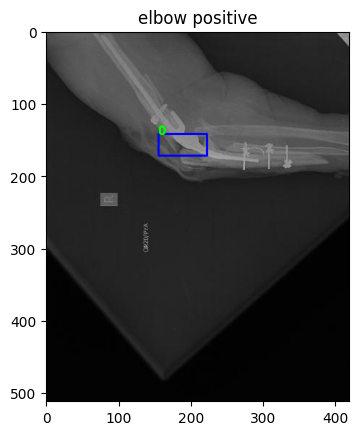

In [13]:

from utils.visualization_funcs import plot_bbox


idx = 550
plot_bbox(image = cv2.imread(images[idx]), 
          class_id = class_ids[idx], 
          bbox = bboxes[idx],
          label=class_mapping[class_ids[idx]])

[1353, 961, 405, 1730, 1844, 1780, 582, 907]


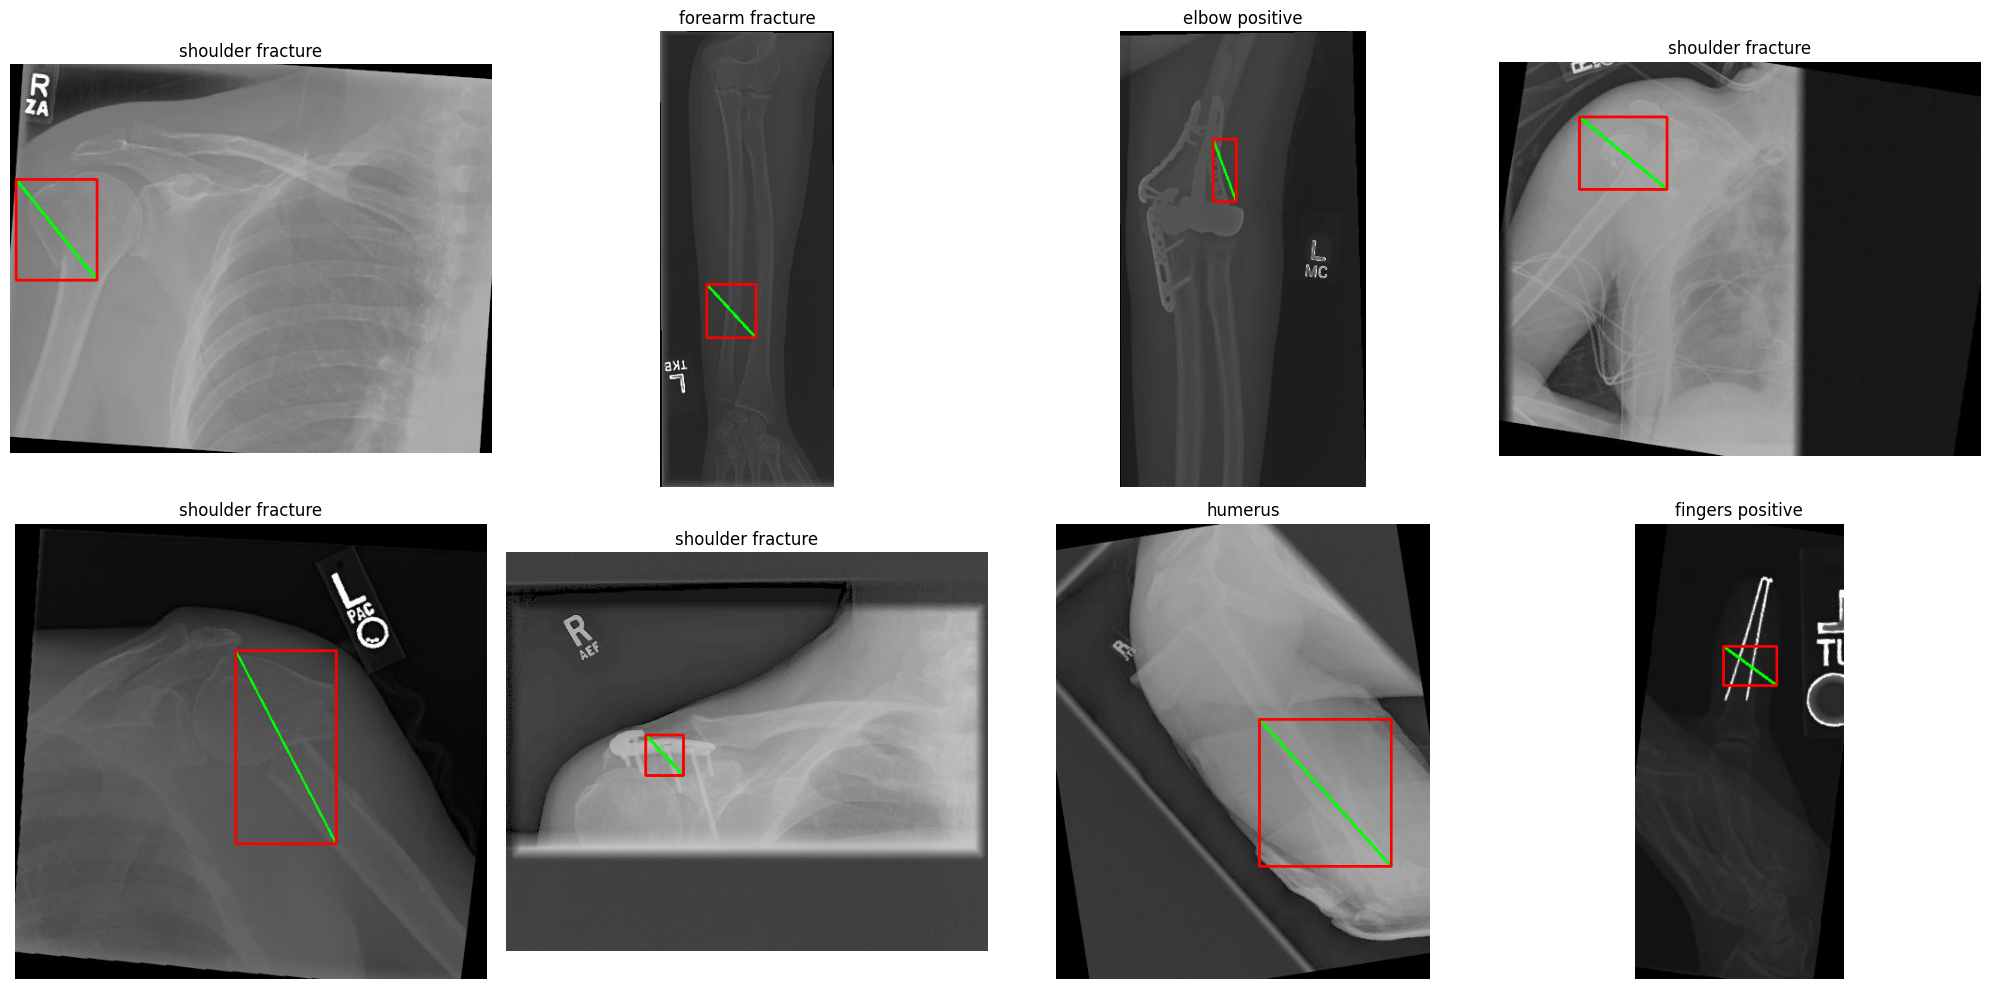

In [14]:

from utils.visualization_funcs import plot_multiple_images

plot_multiple_images(image_paths=images, bboxes=bboxes, class_ids=class_ids, class_mapping=class_mapping)

### Training Dataset setup

In [15]:
preparer_train_ds = PrepareDataset(image_dir=TRAIN_IMAGE_DIR,
                                   label_dir=TRAIN_LABELS_DIR)
image_paths, labels, bboxes = preparer_train_ds.get_dataset()
len(image_paths), len(labels), len(bboxes)

0it [00:00, ?it/s]

(2088, 2088, 2088)

In [16]:
bboxes_tensor = tf.ragged.constant(bboxes)
classes_tensor = tf.ragged.constant(labels)
image_paths_tensor = tf.ragged.constant(image_paths)

train_data = tf.data.Dataset.from_tensor_slices(
    (image_paths_tensor, classes_tensor, bboxes_tensor))

I0000 00:00:1739346362.333787   11974 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1081 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [17]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    print(image.shape)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [18]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

(None, None, 3)


In [19]:
inputs = next(iter(train_ds.take(1)))
images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
image = images[0].numpy()
images[0].get_shape()

TensorShape([512, None, 3])